<a href="https://colab.research.google.com/github/eliza-wollinger/eletric-motor-analisys/blob/main/dashboard_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electric Motor Temperature Dataset

---

### Source
**Paderborn University**  
*Power Electronics and Electrical Drives (LEA)*  
Professor Dr.-Ing. Joachim Böcker

---

### Description
This dataset contains **185 hours** of sensor recordings from a **permanent magnet synchronous motor (PMSM)**,
sampled at **2 Hz**. It includes electrical signals, motor speed, torque, and temperature measurements from the
**stator**, **rotor (permanent magnet)**, **coolant**, and **ambient environment**.

---

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "wkirgsn/electric-motor-temperature",
    path="measures_v2.csv"
)

print(df.head())

Using Colab cache for faster access to the 'electric-motor-temperature' dataset.
        u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417          17  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615          17  
3  0.000026  0.002046  24.554018    18.330833  19.850647  0.238303          17  
4 -0.064317  0.037184  24.565397    18.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
u_q,1330816.0,54.279005,44.173234,-25.290930,12.069925,48.938181,90.034393,133.036994
coolant,1330816.0,36.229995,21.786149,10.623751,18.698135,26.900141,49.857487,101.598512
stator_winding,1330816.0,66.342745,28.672061,18.585815,42.787957,65.110129,88.141137,141.362885
u_d,1330816.0,-25.133809,63.091972,-131.530411,-78.690904,-7.429755,1.470271,131.469788
stator_tooth,1330816.0,56.878582,22.952233,18.133976,38.416012,56.036345,75.586682,111.946423
motor_speed,1330816.0,2202.080728,1859.663350,-275.549144,317.110665,1999.976685,3760.639058,6000.015137
i_d,1330816.0,-68.716810,64.933233,-278.003632,-115.406060,-51.093763,-2.979688,0.051897
i_q,1330816.0,37.412782,92.181880,-293.426793,1.095863,15.774007,100.612150,301.707855
pm,1330816.0,58.506776,19.001498,20.856956,43.151582,60.266287,72.008371,113.606628
stator_yoke,1330816.0,48.187965,19.991004,18.076689,31.990333,45.625509,61.460828,101.147964


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle, Circle, Wedge, FancyBboxPatch
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from scipy.ndimage import gaussian_filter1d
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.ndimage import gaussian_filter

from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

Create plots
Generating...
saved as: component_temp_styles.gif


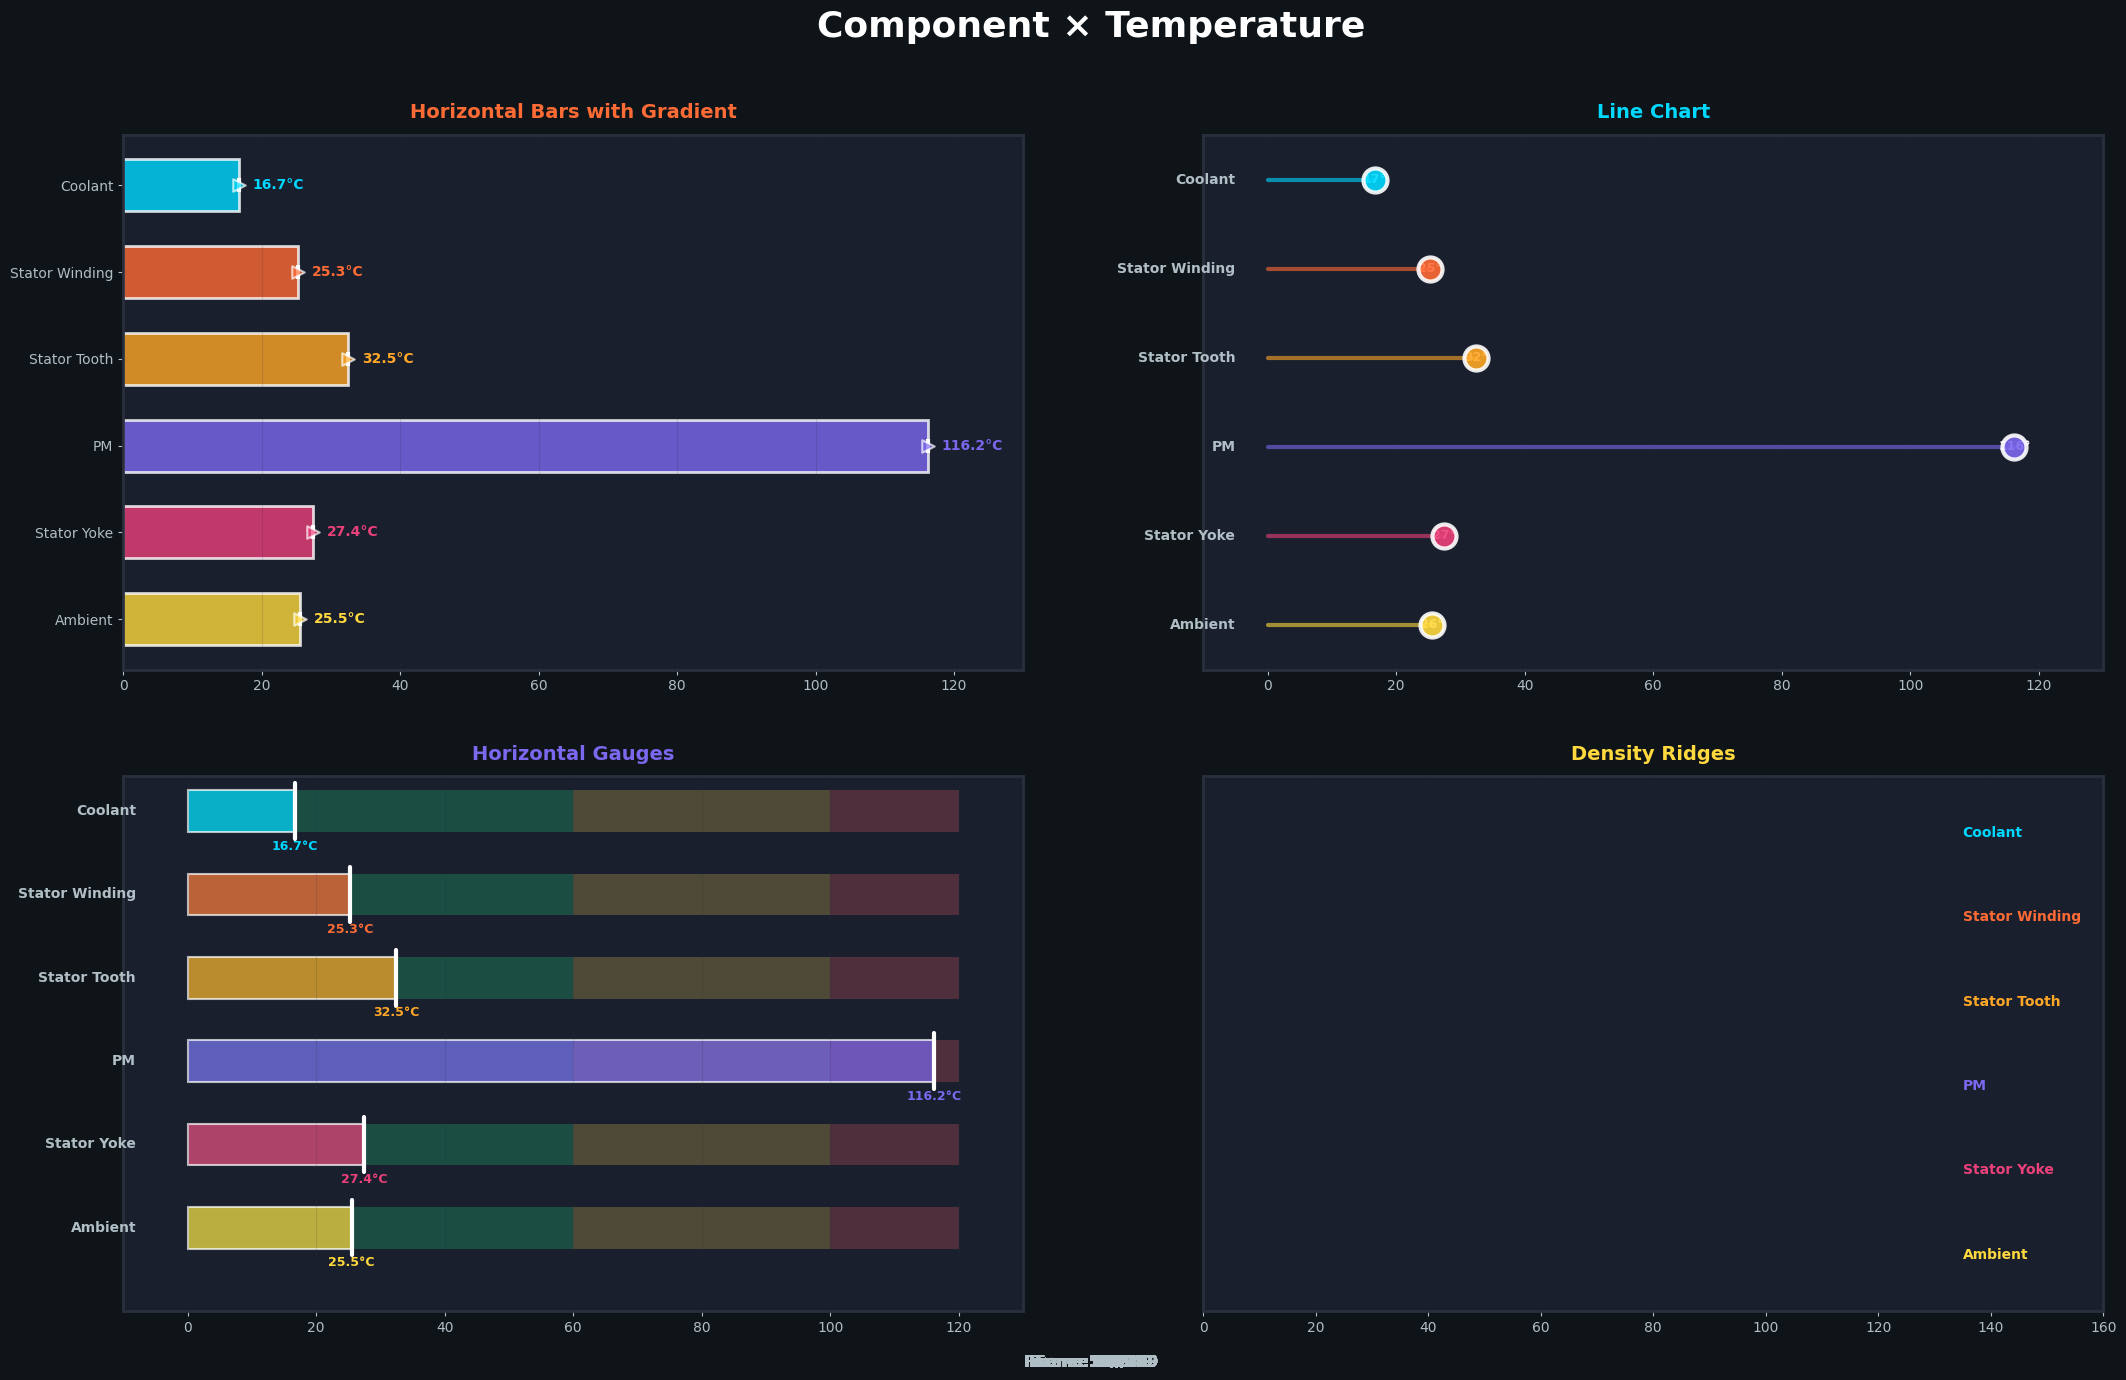

In [ ]:
np.random.seed(42)
n_samples = 50000

df = pd.DataFrame({
    'ambient': np.random.normal(24.57, 1.93, n_samples),
    'coolant': np.random.normal(16.04, 6.23, n_samples),
    'u_d': np.random.normal(-25.13, 63.09, n_samples),
    'u_q': np.random.normal(16.05, 4.27, n_samples),
    'motor_speed': np.random.normal(2202.08, 1859.66, n_samples),
    'torque': np.random.normal(31.11, 77.14, n_samples),
    'i_d': np.random.normal(-68.72, 64.93, n_samples),
    'i_q': np.random.normal(37.41, 92.18, n_samples),
    'pm': np.random.normal(58.51, 19.00, n_samples),
    'stator_yoke': np.random.normal(48.19, 19.99, n_samples),
    'stator_tooth': np.random.normal(56.88, 22.95, n_samples),
    'stator_winding': np.random.normal(16.07, 6.34, n_samples),
    'profile_id': np.random.randint(2, 82, n_samples)
})

# Clipping
df['ambient'] = df['ambient'].clip(8, 35)
df['coolant'] = df['coolant'].clip(10, 102)
df['pm'] = df['pm'].clip(20, 120)
df['stator_yoke'] = df['stator_yoke'].clip(18, 110)
df['stator_tooth'] = df['stator_tooth'].clip(18, 115)
df['stator_winding'] = df['stator_winding'].clip(18, 145)
df['motor_speed'] = df['motor_speed'].clip(-300, 6000)
df['torque'] = df['torque'].clip(-250, 270)

# CONFIG
temp_vars = ['coolant', 'stator_winding', 'stator_tooth', 'pm', 'stator_yoke', 'ambient']
component_labels = ['Coolant', 'Stator Winding', 'Stator Tooth', 'PM', 'Stator Yoke', 'Ambient']
n_components = len(temp_vars)

n_frames = 150
df_anim = df.iloc[:n_frames].copy()

# COLORS
BG_COLOR = '#0f1419'
CARD_BG = '#1a1f2e'
ACCENT_PRIMARY = '#FF6B35'
ACCENT_SECONDARY = '#00D9FF'
ACCENT_TERTIARY = '#7B68EE'
SUCCESS = '#00E676'
WARNING = '#FFD93D'
DANGER = '#FF5252'
TEXT_PRIMARY = '#FFFFFF'
TEXT_SECONDARY = '#B0BEC5'
GRID_COLOR = '#2a2f3e'

component_colors = [ACCENT_SECONDARY, ACCENT_PRIMARY, '#FFA726',
                   ACCENT_TERTIARY, '#EC407A', WARNING]

print(f"Create plots")

# PLOT WITH 4 SUB
fig = plt.figure(figsize=(22, 14))
fig.patch.set_facecolor(BG_COLOR)

fig.text(0.5, 0.97, 'Component × Temperature',
         fontsize=26, fontweight='bold', color=TEXT_PRIMARY, ha='center')

gs = GridSpec(2, 2, figure=fig, hspace=0.20, wspace=0.20,
              left=0.06, right=0.96, top=0.90, bottom=0.06)

# GRADIENT
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_facecolor(CARD_BG)

for spine in ax1.spines.values():
    spine.set_edgecolor(GRID_COLOR)
    spine.set_linewidth(2)

ax1.set_title('Horizontal Bars with Gradient',
              fontsize=14, fontweight='bold', color=ACCENT_PRIMARY, pad=12)
ax1.set_xlabel('Temperature (°C)', fontweight='600', color=TEXT_SECONDARY, fontsize=10)
ax1.set_ylabel('Component', fontweight='600', color=TEXT_SECONDARY, fontsize=10)

# LINE CHART
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_facecolor(CARD_BG)

for spine in ax2.spines.values():
    spine.set_edgecolor(GRID_COLOR)
    spine.set_linewidth(2)

ax2.set_title('Line Chart',
              fontsize=14, fontweight='bold', color=ACCENT_SECONDARY, pad=12)
ax2.set_xlabel('Temperature (°C)', fontweight='600', color=TEXT_SECONDARY, fontsize=10)
ax2.set_ylabel('Component', fontweight='600', color=TEXT_SECONDARY, fontsize=10)

# GAUGE
ax3 = fig.add_subplot(gs[1, 0])
ax3.set_facecolor(CARD_BG)

for spine in ax3.spines.values():
    spine.set_edgecolor(GRID_COLOR)
    spine.set_linewidth(2)

ax3.set_title('STYLE 3: Horizontal Gauges',
              fontsize=14, fontweight='bold', color=ACCENT_TERTIARY, pad=12)
ax3.set_xlabel('Temperature (°C)', fontweight='600', color=TEXT_SECONDARY, fontsize=10)
ax3.set_ylabel('Component', fontweight='600', color=TEXT_SECONDARY, fontsize=10)

# DENSITY
ax4 = fig.add_subplot(gs[1, 1])
ax4.set_facecolor(CARD_BG)

for spine in ax4.spines.values():
    spine.set_edgecolor(GRID_COLOR)
    spine.set_linewidth(2)

ax4.set_title('STYLE 4: Density Ridges',
              fontsize=14, fontweight='bold', color=WARNING, pad=12)
ax4.set_xlabel('Temperature (°C)', fontweight='600', color=TEXT_SECONDARY, fontsize=10)
ax4.set_ylabel('Component', fontweight='600', color=TEXT_SECONDARY, fontsize=10)

def animate(frame):

    current_data = df_anim.iloc[:frame+1]

    # GRADIENT BAR
    ax1.clear()
    ax1.set_facecolor(CARD_BG)
    ax1.set_title('Horizontal Bars with Gradient',
                  fontsize=14, fontweight='bold', color=ACCENT_PRIMARY, pad=12)

    for i, (var, color, label) in enumerate(zip(temp_vars, component_colors, component_labels)):
        current_temp = current_data[var].iloc[-1]
        avg_temp = current_data[var].mean()
        max_temp = current_data[var].max()

        bar = ax1.barh(i, current_temp, height=0.6, color=color, alpha=0.8,
                       edgecolor='white', linewidth=2)

        # average
        ax1.scatter([avg_temp], [i], c='white', s=100, marker='|',
                   linewidths=3, zorder=10)

        # maximum
        ax1.scatter([max_temp], [i], c=color, s=80, marker='>',
                   edgecolors='white', linewidths=1.5, zorder=10, alpha=0.7)

        # label
        ax1.text(current_temp + 2, i, f'{current_temp:.1f}°C',
                va='center', fontsize=10, fontweight='bold', color=color)

    ax1.set_yticks(range(n_components))
    ax1.set_yticklabels(component_labels, fontsize=10, color=TEXT_SECONDARY)
    ax1.set_xlim(0, 130)
    ax1.tick_params(colors=TEXT_SECONDARY)
    ax1.grid(True, alpha=0.15, color=GRID_COLOR, axis='x')
    ax1.invert_yaxis()

    for spine in ax1.spines.values():
        spine.set_edgecolor(GRID_COLOR)
        spine.set_linewidth(2)

    # LINE CHART
    ax2.clear()
    ax2.set_facecolor(CARD_BG)
    ax2.set_title('Line Chart',
                  fontsize=14, fontweight='bold', color=ACCENT_SECONDARY, pad=12)

    for i, (var, color, label) in enumerate(zip(temp_vars, component_colors, component_labels)):
        current_temp = current_data[var].iloc[-1]
        min_temp = current_data[var].min()
        max_temp = current_data[var].max()

        # range (min-max)
        ax2.plot([min_temp, max_temp], [i, i], color=color, alpha=0.3,
                linewidth=8, solid_capstyle='round')

        ax2.plot([0, current_temp], [i, i], color=color, alpha=0.6,
                linewidth=3, solid_capstyle='round')

        ax2.scatter([current_temp], [i], c=color, s=300, alpha=0.9,
                   edgecolors='white', linewidths=3, zorder=10)

        # circle value
        ax2.text(current_temp, i, f'{current_temp:.0f}°',
                ha='center', va='center', fontsize=9,
                fontweight='bold', color='white')

        # component label
        ax2.text(-5, i, label, ha='right', va='center',
                fontsize=10, color=TEXT_SECONDARY, fontweight='600')

    ax2.set_xlim(-10, 130)
    ax2.set_ylim(-0.5, n_components - 0.5)
    ax2.set_yticks([])
    ax2.tick_params(colors=TEXT_SECONDARY)
    ax2.grid(True, alpha=0.15, color=GRID_COLOR, axis='x')
    ax2.invert_yaxis()

    for spine in ax2.spines.values():
        spine.set_edgecolor(GRID_COLOR)
        spine.set_linewidth(2)

    # GAUGE
    ax3.clear()
    ax3.set_facecolor(CARD_BG)
    ax3.set_title('Horizontal Gauges',
                  fontsize=14, fontweight='bold', color=ACCENT_TERTIARY, pad=12)

    for i, (var, color, label) in enumerate(zip(temp_vars, component_colors, component_labels)):
        current_temp = current_data[var].iloc[-1]
        y_pos = i * 1.2

        # gauge background
        ax3.add_patch(Rectangle((0, y_pos - 0.3), 120, 0.6,
                                facecolor='#2a2f3e', alpha=0.5,
                                edgecolor='none'))

        # temperature
        ax3.add_patch(Rectangle((0, y_pos - 0.3), 60, 0.6,
                                facecolor=SUCCESS, alpha=0.2, edgecolor='none'))
        ax3.add_patch(Rectangle((60, y_pos - 0.3), 40, 0.6,
                                facecolor=WARNING, alpha=0.2, edgecolor='none'))
        ax3.add_patch(Rectangle((100, y_pos - 0.3), 20, 0.6,
                                facecolor=DANGER, alpha=0.2, edgecolor='none'))

        ax3.add_patch(Rectangle((0, y_pos - 0.3), current_temp, 0.6,
                                facecolor=color, alpha=0.7,
                                edgecolor='white', linewidth=1.5))

        ax3.plot([current_temp, current_temp], [y_pos - 0.4, y_pos + 0.4],
                color='white', linewidth=3, solid_capstyle='round')

        # label
        ax3.text(-8, y_pos, label, ha='right', va='center',
                fontsize=10, color=TEXT_SECONDARY, fontweight='600')

        # data
        ax3.text(current_temp, y_pos + 0.6, f'{current_temp:.1f}°C',
                ha='center', va='bottom', fontsize=9,
                fontweight='bold', color=color)

    ax3.set_xlim(-10, 130)
    ax3.set_ylim(-0.5, n_components * 1.2)
    ax3.set_yticks([])
    ax3.tick_params(colors=TEXT_SECONDARY)
    ax3.grid(True, alpha=0.15, color=GRID_COLOR, axis='x')
    ax3.invert_yaxis()

    for spine in ax3.spines.values():
        spine.set_edgecolor(GRID_COLOR)
        spine.set_linewidth(2)

    # DENSITY RIDGES
    ax4.clear()
    ax4.set_facecolor(CARD_BG)
    ax4.set_title('Density Ridges',
                  fontsize=14, fontweight='bold', color=WARNING, pad=12)

    spacing = 1.5
    for i, (var, color, label) in enumerate(zip(temp_vars, component_colors, component_labels)):
        temps = current_data[var].values
        y_base = i * spacing

        if len(temps) > 10:
            # density
            density = gaussian_kde(temps)
            temp_range = np.linspace(0, 130, 300)
            density_values = density(temp_range)
            density_values = density_values / density_values.max() * 1.0

            # density
            ax4.fill_between(temp_range, y_base, y_base + density_values,
                            alpha=0.7, color=color, edgecolor='white', linewidth=2)

            # contour line
            ax4.plot(temp_range, y_base + density_values,
                    color='white', linewidth=1.5, alpha=0.8)

            current_temp = temps[-1]
            current_density = density(current_temp)[0]
            current_density = current_density / density_values.max() * 1.0

            ax4.scatter([current_temp], [y_base + current_density],
                       c='white', s=150, edgecolors=color,
                       linewidths=3, zorder=10)

        # label
        ax4.text(135, y_base + 0.5, label, ha='left', va='center',
                fontsize=10, color=color, fontweight='bold')

    ax4.set_xlim(0, 160)
    ax4.set_ylim(-0.5, n_components * spacing)
    ax4.set_yticks([])
    ax4.tick_params(colors=TEXT_SECONDARY)
    ax4.grid(True, alpha=0.15, color=GRID_COLOR, axis='x')
    ax4.invert_yaxis()

    for spine in ax4.spines.values():
        spine.set_edgecolor(GRID_COLOR)
        spine.set_linewidth(2)

    # frame info
    fig.text(0.5, 0.02, f'Frame: {frame}/{n_frames-1}',
             ha='center', fontsize=11, color=TEXT_SECONDARY, fontweight='600')

    return []

print("Generating...")
anim = FuncAnimation(fig, animate, frames=n_frames,
                    interval=67, blit=False, repeat=True)

output_file = 'component_temp_styles.gif'
anim.save(output_file, writer='pillow', fps=15, dpi=100)

print(f"saved as: {output_file}")

150 frames...
Generating...
saved as motor_relationships.gif
150 frames | duration: 10.0s | 15 fps


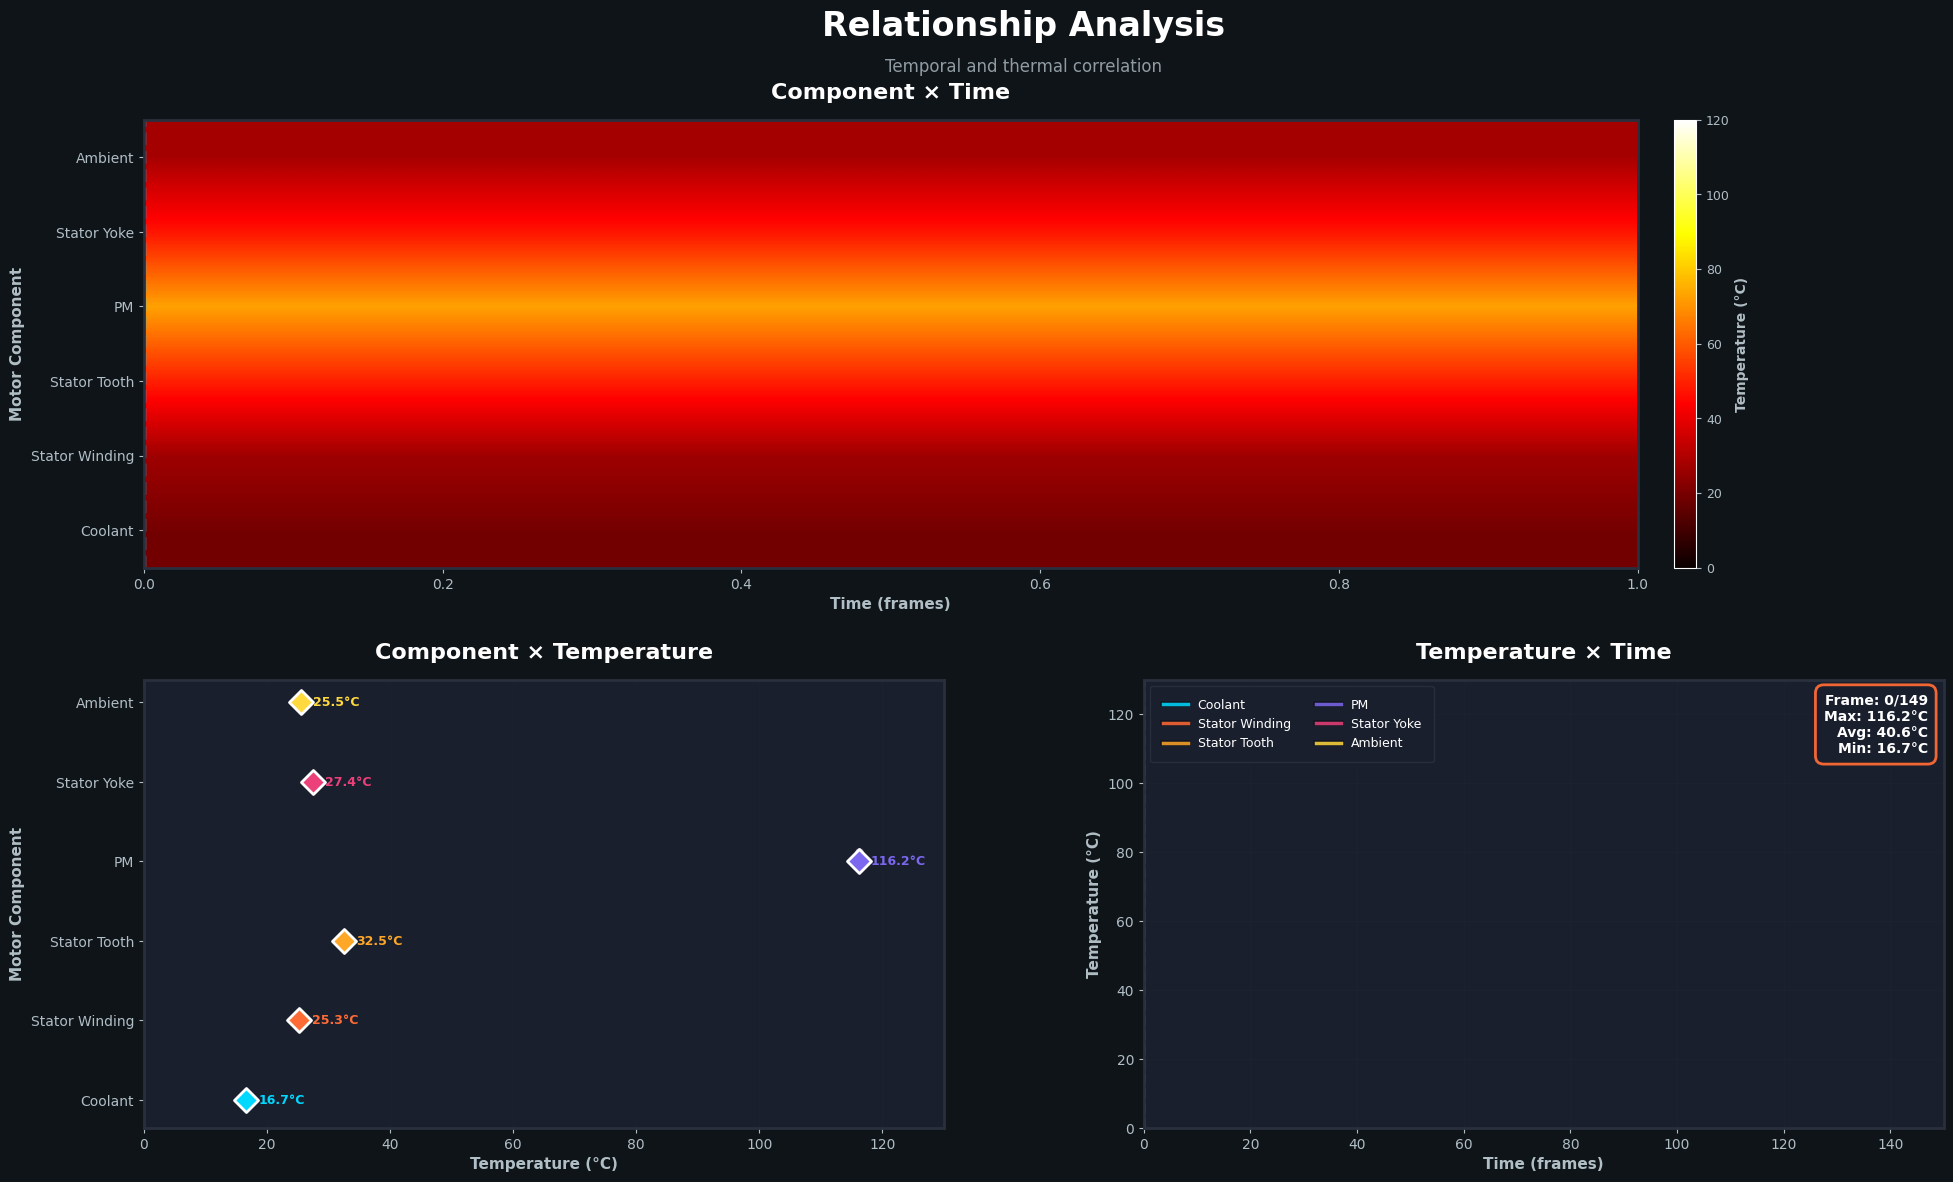

In [ ]:
component_colors = [ACCENT_SECONDARY, ACCENT_PRIMARY, '#FFA726',
                   ACCENT_TERTIARY, '#EC407A', WARNING]

print(f"{n_frames} frames...")

# PLOT WITH 3 SUB
fig = plt.figure(figsize=(20, 12))
fig.patch.set_facecolor(BG_COLOR)

fig.text(0.5, 0.97, 'Relationship Analysis',
         fontsize=24, fontweight='bold', color=TEXT_PRIMARY, ha='center')
fig.text(0.5, 0.94, 'Temporal and thermal correlation',
         fontsize=12, color=TEXT_SECONDARY, alpha=0.8, ha='center')

# grid
gs = GridSpec(2, 2, figure=fig, hspace=0.25, wspace=0.25,
              left=0.06, right=0.96, top=0.90, bottom=0.06)

# COMPONENT × TIME
# HEATMAP
ax1 = fig.add_subplot(gs[0, :])
ax1.set_facecolor(CARD_BG)

#
for spine in ax1.spines.values():
    spine.set_edgecolor(GRID_COLOR)
    spine.set_linewidth(2)

ax1.set_title('Component × Time (Heatmap)',
              fontsize=16, fontweight='bold', color=TEXT_PRIMARY, pad=15)

ax1.set_xlabel('Time (frames)', fontweight='600', color=TEXT_SECONDARY, fontsize=11)
ax1.set_ylabel('Motor Component', fontweight='600', color=TEXT_SECONDARY, fontsize=11)
ax1.set_yticks(range(n_components))
ax1.set_yticklabels(component_labels, fontsize=10, color=TEXT_SECONDARY)
ax1.tick_params(colors=TEXT_SECONDARY, labelsize=10)

heatmap = None
cbar1 = None

# COMPONENT × TEMPERATURE
ax2 = fig.add_subplot(gs[1, 0])
ax2.set_facecolor(CARD_BG)

for spine in ax2.spines.values():
    spine.set_edgecolor(GRID_COLOR)
    spine.set_linewidth(2)

ax2.set_title('Component × Temperature',
              fontsize=16, fontweight='bold', color=TEXT_PRIMARY, pad=15)

ax2.set_xlabel('Temperature (°C)', fontweight='600', color=TEXT_SECONDARY, fontsize=11)
ax2.set_ylabel('Motor Component', fontweight='600', color=TEXT_SECONDARY, fontsize=11)
ax2.set_yticks(range(n_components))
ax2.set_yticklabels(component_labels, fontsize=10, color=TEXT_SECONDARY)
ax2.tick_params(colors=TEXT_SECONDARY, labelsize=10)
ax2.grid(True, alpha=0.15, color=GRID_COLOR, axis='x')

# TEMPERATURE × TIME
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_facecolor(CARD_BG)

for spine in ax3.spines.values():
    spine.set_edgecolor(GRID_COLOR)
    spine.set_linewidth(2)

ax3.set_title('Temperature × Time',
              fontsize=16, fontweight='bold', color=TEXT_PRIMARY, pad=15)

ax3.set_xlabel('Time (frames)', fontweight='600', color=TEXT_SECONDARY, fontsize=11)
ax3.set_ylabel('Temperature (°C)', fontweight='600', color=TEXT_SECONDARY, fontsize=11)
ax3.tick_params(colors=TEXT_SECONDARY, labelsize=10)
ax3.grid(True, alpha=0.15, color=GRID_COLOR)
ax3.set_xlim(0, n_frames)
ax3.set_ylim(0, 130)

lines = {}
for var, color, label in zip(temp_vars, component_colors, component_labels):
    line, = ax3.plot([], [], lw=2.5, color=color, label=label, alpha=0.85,
                     path_effects=[path_effects.withStroke(linewidth=4,
                                  foreground='black', alpha=0.3)])
    lines[var] = line

ax3.legend(loc='upper left', ncol=2, fontsize=9, framealpha=0.95,
          facecolor=CARD_BG, edgecolor=GRID_COLOR, borderpad=1)

def animate(frame):
    global heatmap, cbar1
    # COMPONENT × TIME
    ax1.clear()
    ax1.set_facecolor(CARD_BG)

    ax1.set_title('Component × Time',
                  fontsize=16, fontweight='bold', color=TEXT_PRIMARY, pad=15)
    ax1.set_xlabel('Time (frames)', fontweight='600', color=TEXT_SECONDARY, fontsize=11)
    ax1.set_ylabel('Motor Component', fontweight='600', color=TEXT_SECONDARY, fontsize=11)

    window = min(100, frame + 1)
    start_idx = max(0, frame - window + 1)

    heatmap_data = np.zeros((n_components, window))
    for i, var in enumerate(temp_vars):
        heatmap_data[i, :] = df_anim[var].iloc[start_idx:frame+1].values

    # heatmap blur
    from scipy.ndimage import gaussian_filter
    heatmap_data = gaussian_filter(heatmap_data, sigma=0.8)

    # plot heatmap
    im = ax1.imshow(heatmap_data, aspect='auto', cmap='hot',
                   interpolation='bilinear', origin='lower',
                   extent=[start_idx, frame+1, -0.5, n_components-0.5],
                   vmin=0, vmax=120)

    ax1.set_yticks(range(n_components))
    ax1.set_yticklabels(component_labels, fontsize=10, color=TEXT_SECONDARY)
    ax1.tick_params(colors=TEXT_SECONDARY, labelsize=10)

    # colorbar
    if cbar1 is None:
        cbar1 = plt.colorbar(im, ax=ax1, pad=0.02)
        cbar1.set_label('Temperature (°C)', color=TEXT_SECONDARY, fontweight='600')
        cbar1.ax.tick_params(colors=TEXT_SECONDARY, labelsize=9)

    ax1.axvline(x=frame, color=ACCENT_SECONDARY, linewidth=2.5,
               linestyle='--', alpha=0.8, label='Current Frame')

    for spine in ax1.spines.values():
        spine.set_edgecolor(GRID_COLOR)
        spine.set_linewidth(2)

    # COMPONENT × TEMPERATURE
    ax2.clear()
    ax2.set_facecolor(CARD_BG)

    ax2.set_title('Component × Temperature',
                  fontsize=16, fontweight='bold', color=TEXT_PRIMARY, pad=15)
    ax2.set_xlabel('Temperature (°C)', fontweight='600', color=TEXT_SECONDARY, fontsize=11)
    ax2.set_ylabel('Motor Component', fontweight='600', color=TEXT_SECONDARY, fontsize=11)

    current_data = df_anim.iloc[:frame+1]

    for i, (var, color, label) in enumerate(zip(temp_vars, component_colors, component_labels)):
        temps = current_data[var].values

        from scipy.stats import gaussian_kde

        if len(temps) > 10:
            density = gaussian_kde(temps)
            temp_range = np.linspace(temps.min(), temps.max(), 100)
            density_values = density(temp_range)

            density_values = density_values / density_values.max() * 0.35

            ax2.fill_betweenx(temp_range, i-density_values, i+density_values,
                             alpha=0.3, color=color, edgecolor='none')

        # Box plot
        # bp = ax2.boxplot([temps], positions=[i], vert=False, widths=0.5,
        #                 patch_artist=True, showfliers=False,
        #                 boxprops=dict(facecolor=color, alpha=0.6, edgecolor='white', linewidth=1.5),
        #                 whiskerprops=dict(color='white', linewidth=1.5),
        #                 capprops=dict(color='white', linewidth=1.5),
        #                 medianprops=dict(color='white', linewidth=2.5))

        recent_temps = temps[-20:]
        y_scatter = i + np.random.normal(0, 0.08, len(recent_temps))
        ax2.scatter(recent_temps, y_scatter, c=color, s=30, alpha=0.6,
                   edgecolors='white', linewidth=0.5, zorder=10)

        # marked value
        current_temp = temps[-1]
        ax2.scatter([current_temp], [i], c=color, s=150, alpha=1.0,
                   edgecolors='white', linewidth=2, zorder=15, marker='D')

        # label
        ax2.text(current_temp + 2, i, f'{current_temp:.1f}°C',
                va='center', fontsize=9, fontweight='bold', color=color)

    ax2.set_yticks(range(n_components))
    ax2.set_yticklabels(component_labels, fontsize=10, color=TEXT_SECONDARY)
    ax2.set_xlim(0, 130)
    ax2.tick_params(colors=TEXT_SECONDARY, labelsize=10)
    ax2.grid(True, alpha=0.15, color=GRID_COLOR, axis='x')

    for spine in ax2.spines.values():
        spine.set_edgecolor(GRID_COLOR)
        spine.set_linewidth(2)

    # TEMPERATURE × TIME
    for var, line in lines.items():
        x_data = np.arange(frame + 1)
        y_data = df_anim[var].iloc[:frame + 1].values
        line.set_data(x_data, y_data)

    if hasattr(ax3, 'vline'):
        ax3.vline.remove()
    ax3.vline = ax3.axvline(x=frame, color=ACCENT_SECONDARY, linewidth=2,
                           linestyle='--', alpha=0.6)

    # info box
    current_temps = df_anim[temp_vars].iloc[frame]
    max_temp = current_temps.max()
    min_temp = current_temps.min()
    avg_temp = current_temps.mean()

    info_text = (f'Frame: {frame}/{n_frames-1}\n'
                f'Max: {max_temp:.1f}°C\n'
                f'Avg: {avg_temp:.1f}°C\n'
                f'Min: {min_temp:.1f}°C')

    for txt in ax3.texts:
        txt.remove()

    ax3.text(0.98, 0.97, info_text,
            transform=ax3.transAxes,
            ha='right', va='top', fontsize=10,
            fontweight='600', color=TEXT_PRIMARY,
            bbox=dict(boxstyle='round,pad=0.6',
                     facecolor=CARD_BG,
                     edgecolor=ACCENT_PRIMARY,
                     alpha=0.95, linewidth=2))

    return [im] + list(lines.values())

print("Generating...")
anim = FuncAnimation(fig, animate, frames=n_frames,
                    interval=67, blit=False, repeat=True)

# save
output_file = 'motor_relationships.gif'
anim.save(output_file, writer='pillow', fps=15, dpi=100)

print(f"saved as {output_file}")
print(f"{n_frames} frames | duration: {n_frames/15:.1f}s | 15 fps")

Generating...
saved as motor_temp_3d_isometric.gif
250 frames | Duração: 16.7s | 15 fps


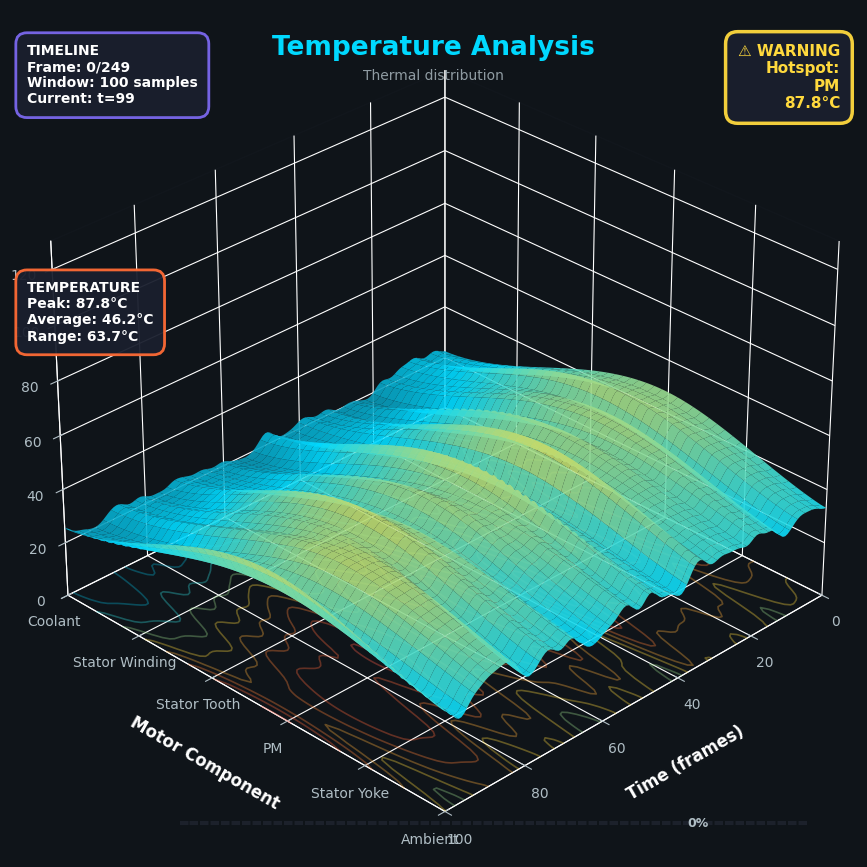

In [ ]:
# config
n_frames = 250
window_size = 100
resolution = 150

# meshgrid
X = np.linspace(0, window_size, resolution)
Y = np.linspace(0, n_components-1, resolution)
X_mesh, Y_mesh = np.meshgrid(X, Y)

# ISOMETRIC PLOT
fig = plt.figure(figsize=(18, 11))
fig.patch.set_facecolor(BG_COLOR)

ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor(BG_COLOR)

# axis
ax.set_xlim(0, window_size)
ax.set_ylim(0, n_components-1)
ax.set_zlim(0, 130)

ax.set_xlabel('Time (frames)', fontweight='bold', color=TEXT_PRIMARY,
              labelpad=15, fontsize=12)
ax.set_ylabel('Motor Component', fontweight='bold', color=TEXT_PRIMARY,
              labelpad=15, fontsize=12)
ax.set_zlabel('Temperature (°C)', fontweight='bold', color=TEXT_PRIMARY,
              labelpad=15, fontsize=12)

# component label
ax.set_yticks(range(n_components))
ax.set_yticklabels(component_labels, fontsize=10, color=TEXT_SECONDARY)
ax.tick_params(colors=TEXT_SECONDARY, labelsize=10)

ELEVATION = 30
AZIMUTH = 45    # 45° = isométric
ax.view_init(elev=ELEVATION, azim=AZIMUTH)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('#2a2f3e')
ax.yaxis.pane.set_edgecolor('#2a2f3e')
ax.zaxis.pane.set_edgecolor('#2a2f3e')
ax.xaxis.pane.set_alpha(0.1)
ax.yaxis.pane.set_alpha(0.1)
ax.zaxis.pane.set_alpha(0.1)

# grid
ax.grid(True, alpha=0.2, color='white', linewidth=0.5, linestyle=':')

# COLORMAP PERSONALIZADO
colors_list = ['#1a1f2e', '#00D9FF', '#FFD93D', '#FF6B35', '#FF5252']
n_bins = 256
cmap_custom = LinearSegmentedColormap.from_list('motor_temp', colors_list, N=n_bins)

# SURFACE
def create_smooth_surface(frame, window_size, resolution):
    start_idx = frame
    end_idx = frame + window_size
    Z_base = np.zeros((n_components, window_size))

    for i, var in enumerate(temp_vars):
        data_slice = df_anim[var].iloc[start_idx:end_idx].values

        if len(data_slice) < window_size:
            padding_needed = window_size - len(data_slice)
            padding = np.full(padding_needed, data_slice[0] if len(data_slice) > 0 else 20)
            data_slice = np.concatenate([data_slice, padding])

        Z_base[i, :] = data_slice[:window_size]

    # gaussian blur
    Z_base = gaussian_filter(Z_base, sigma=1.2)

    x_orig = np.linspace(0, window_size, window_size)
    y_orig = np.linspace(0, n_components-1, n_components)

    interp_func = RectBivariateSpline(y_orig, x_orig, Z_base, kx=3, ky=3)

    x_high = np.linspace(0, window_size, resolution)
    y_high = np.linspace(0, n_components-1, resolution)

    Z_smooth = interp_func(y_high, x_high)

    Z_smooth = gaussian_filter(Z_smooth, sigma=1.8)

    return Z_smooth

# ANIMATION
surf_plot = None
wire_plot = None
contour_plot = None

def animate(frame):

    global surf_plot, wire_plot, contour_plot

    ax.clear()

    ax.set_xlim(0, window_size)
    ax.set_ylim(0, n_components-1)
    ax.set_zlim(0, 130)

    ax.set_xlabel('Time (frames)', fontweight='bold', color=TEXT_PRIMARY,
                  labelpad=15, fontsize=12)
    ax.set_ylabel('Motor Component', fontweight='bold', color=TEXT_PRIMARY,
                  labelpad=15, fontsize=12)
    ax.set_zlabel('Temperature (°C)', fontweight='bold', color=TEXT_PRIMARY,
                  labelpad=15, fontsize=12)

    ax.set_yticks(range(n_components))
    ax.set_yticklabels(component_labels, fontsize=10, color=TEXT_SECONDARY)
    ax.tick_params(colors=TEXT_SECONDARY, labelsize=10)

    ax.view_init(elev=ELEVATION, azim=AZIMUTH)

    Z = create_smooth_surface(frame, window_size, resolution)

    surf = ax.plot_surface(X_mesh, Y_mesh, Z,
                          cmap=cmap_custom,
                          alpha=0.92,
                          antialiased=True,
                          edgecolor='none',
                          vmin=0,
                          vmax=120,
                          shade=True,
                          lightsource=plt.matplotlib.colors.LightSource(
                              azdeg=315, altdeg=50))

    ax.plot_wireframe(X_mesh, Y_mesh, Z,
                     color='white',
                     alpha=0.06,
                     linewidth=0.3,
                     rstride=12,
                     cstride=12)

    ax.contour(X_mesh, Y_mesh, Z,
              zdir='z', offset=0,
              levels=8,
              cmap=cmap_custom,
              alpha=0.35,
              linewidths=1.2)

    current_idx = min(frame + window_size - 1, len(df_anim) - 1)
    current_temps = df_anim[temp_vars].iloc[current_idx]
    max_temp = current_temps.max()
    min_temp = current_temps.min()
    avg_temp = current_temps.mean()
    max_component = component_labels[current_temps.argmax()]

    ax.text2D(0.5, 0.97,
              'Temperature Analysis',
              transform=ax.transAxes,
              ha='center', va='top', fontsize=19,
              fontweight='bold', color=ACCENT_SECONDARY)

    ax.text2D(0.5, 0.93,
              'Thermal distribution',
              transform=ax.transAxes,
              ha='center', va='top', fontsize=10,
              color=TEXT_SECONDARY, alpha=0.8)

    # left infobox
    timeline_text = (f'TIMELINE\n'
                    f'Frame: {frame}/{n_frames-1}\n'
                    f'Window: {window_size} samples\n'
                    f'Current: t={current_idx}')

    ax.text2D(0.02, 0.96,
              timeline_text,
              transform=ax.transAxes,
              ha='left', va='top', fontsize=10,
              fontweight='600', color=TEXT_PRIMARY,
              bbox=dict(boxstyle='round,pad=0.8',
                       facecolor=CARD_BG,
                       edgecolor=ACCENT_TERTIARY,
                       alpha=0.95,
                       linewidth=2))

    # central infobox
    metrics_text = (f'TEMPERATURE\n'
                   f'Peak: {max_temp:.1f}°C\n'
                   f'Average: {avg_temp:.1f}°C\n'
                   f'Range: {max_temp - min_temp:.1f}°C')

    ax.text2D(0.02, 0.68,
              metrics_text,
              transform=ax.transAxes,
              ha='left', va='top', fontsize=10,
              fontweight='600', color=TEXT_PRIMARY,
              bbox=dict(boxstyle='round,pad=0.8',
                       facecolor=CARD_BG,
                       edgecolor=ACCENT_PRIMARY,
                       alpha=0.95,
                       linewidth=2))

    # status
    if max_temp < 60:
        status = "NORMAL"
        status_color = SUCCESS
        status_icon = "✓"
    elif max_temp < 100:
        status = "WARNING"
        status_color = WARNING
        status_icon = "⚠"
    else:
        status = "CRITICAL"
        status_color = DANGER
        status_icon = "✕"

    status_text = (f'{status_icon} {status}\n'
                  f'Hotspot:\n'
                  f'{max_component}\n'
                  f'{max_temp:.1f}°C')

    ax.text2D(0.98, 0.96,
              status_text,
              transform=ax.transAxes,
              ha='right', va='top', fontsize=11,
              fontweight='bold', color=status_color,
              bbox=dict(boxstyle='round,pad=0.8',
                       facecolor=CARD_BG,
                       edgecolor=status_color,
                       alpha=0.95,
                       linewidth=2.5))

    progress = frame / (n_frames - 1)
    progress_width = 0.6
    progress_x_start = 0.2

    ax.text2D(progress_x_start, 0.04,
              '▬' * 60,
              transform=ax.transAxes,
              ha='left', va='center', fontsize=8,
              color='#2a2f3e', alpha=0.5)

    filled_bars = int(60 * progress)
    if filled_bars > 0:
        ax.text2D(progress_x_start, 0.04,
                  '▬' * filled_bars,
                  transform=ax.transAxes,
                  ha='left', va='center', fontsize=8,
                  color=ACCENT_SECONDARY, alpha=0.9)

    ax.text2D(progress_x_start + progress_width, 0.04,
              f'{progress*100:.0f}%',
              transform=ax.transAxes,
              ha='left', va='center', fontsize=9,
              color=TEXT_SECONDARY, fontweight='600')

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('#2a2f3e')
    ax.yaxis.pane.set_edgecolor('#2a2f3e')
    ax.zaxis.pane.set_edgecolor('#2a2f3e')
    ax.xaxis.pane.set_alpha(0.1)
    ax.yaxis.pane.set_alpha(0.1)
    ax.zaxis.pane.set_alpha(0.1)

    ax.grid(True, alpha=0.2, color='white', linewidth=0.5, linestyle=':')

    return [surf]


print("Generating...")

anim = FuncAnimation(fig, animate, frames=n_frames, interval=67, blit=False, repeat=True)

# save
output_file = 'motor_temp_3d_isometric.gif'
anim.save(output_file, writer='pillow', fps=15, dpi=100)

duration_seconds = n_frames / 15
print(f"saved as {output_file}")
print(f"{n_frames} frames | Duração: {duration_seconds:.1f}s | 15 fps")

motor_dashboard_modern.gif saved


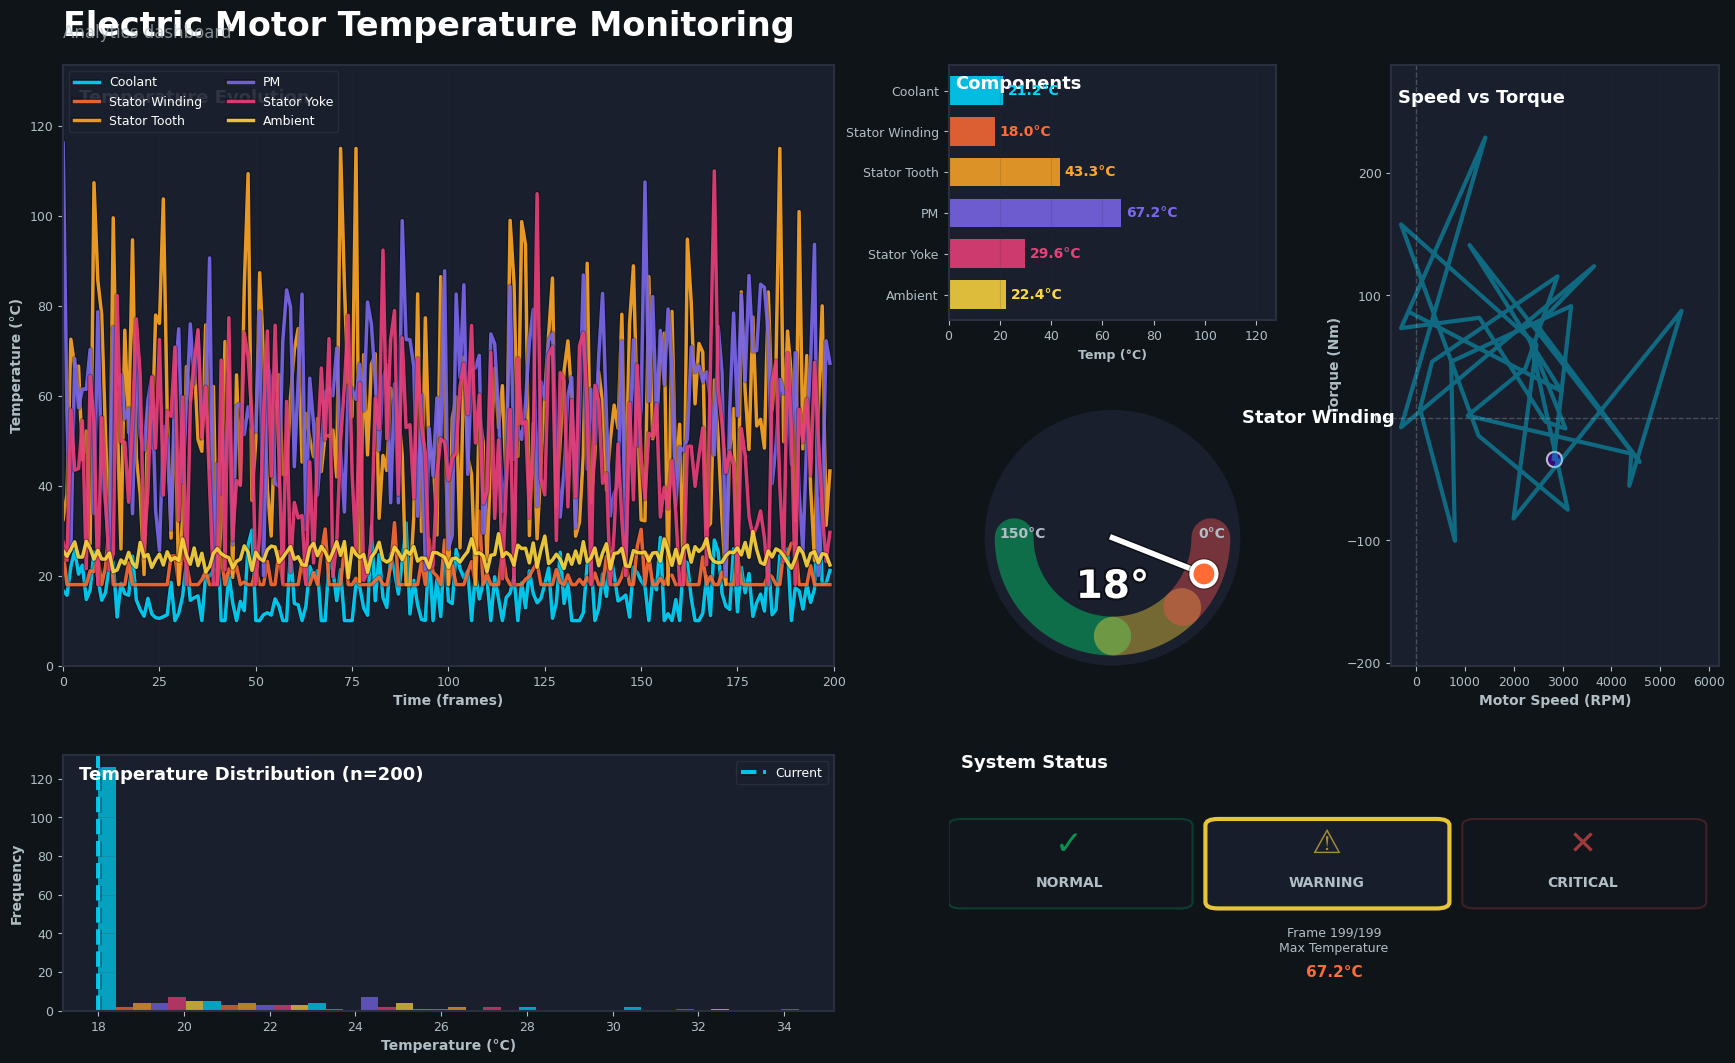

In [ ]:
# Subset para animação
n_frames = min(200, len(df))
df_anim = df.iloc[:n_frames].copy()

temp_vars = ['coolant', 'stator_winding', 'stator_tooth', 'pm', 'stator_yoke', 'ambient']
temp_labels = ['Coolant', 'Stator Winding', 'Stator Tooth', 'PM', 'Stator Yoke', 'Ambient']

# gradient colors
colors = [ACCENT_SECONDARY, ACCENT_PRIMARY, '#FFA726', ACCENT_TERTIARY, '#EC407A', WARNING]

fig = plt.figure(figsize=(18, 11), facecolor=BG_COLOR)
fig.suptitle('Electric Motor Temperature Monitoring',
             fontsize=24, fontweight='bold', color=TEXT_PRIMARY,
             x=0.05, ha='left', y=0.97)

fig.text(0.05, 0.945, 'Analytics dashboard',
         fontsize=12, color=TEXT_SECONDARY, alpha=0.7)

gs = GridSpec(3, 4, figure=fig, hspace=0.35, wspace=0.35,
              left=0.05, right=0.97, top=0.92, bottom=0.06)

def create_card(ax, title, subtitle=None):
    ax.set_facecolor(CARD_BG)

    for spine in ax.spines.values():
        spine.set_edgecolor(GRID_COLOR)
        spine.set_linewidth(1.5)

    ax.text(0.02, 0.96, title, transform=ax.transAxes,
            fontsize=13, fontweight='bold', color=TEXT_PRIMARY,
            va='top')

    if subtitle:
        ax.text(0.02, 0.89, subtitle, transform=ax.transAxes,
                fontsize=9, color=TEXT_SECONDARY, alpha=0.7,
                va='top')

# TIME EVOLUTION
ax1 = fig.add_subplot(gs[0:2, 0:2])
create_card(ax1, 'Temperature Evolution')

lines = {}
for name, color, label in zip(temp_vars, colors, temp_labels):
    line, = ax1.plot([], [], lw=2.5, color=color, label=label, alpha=0.9,
                     path_effects=[path_effects.withStroke(linewidth=4, foreground='black', alpha=0.3)])
    lines[name] = line

ax1.set_xlim(0, n_frames)
ax1.set_ylim(0, df_anim[temp_vars].max().max() * 1.15)
ax1.set_xlabel('Time (frames)', fontweight='600', color=TEXT_SECONDARY, fontsize=10)
ax1.set_ylabel('Temperature (°C)', fontweight='600', color=TEXT_SECONDARY, fontsize=10)
ax1.legend(loc='upper left', ncol=2, fontsize=9, framealpha=0.9,
          facecolor=CARD_BG, edgecolor=GRID_COLOR)
ax1.grid(True, alpha=0.15, color=GRID_COLOR, linewidth=1)
ax1.tick_params(colors=TEXT_SECONDARY, labelsize=9)

# COMPONENTS
ax2 = fig.add_subplot(gs[0, 2])
create_card(ax2, 'Components')

bars = ax2.barh(range(len(temp_vars)), [0]*len(temp_vars),
                color=colors, alpha=0.85, height=0.7,
                edgecolor='white', linewidth=0)

ax2.set_xlim(0, df_anim[temp_vars].max().max() * 1.1)
ax2.set_yticks(range(len(temp_vars)))
ax2.set_yticklabels(temp_labels, fontsize=9, color=TEXT_SECONDARY)
ax2.set_xlabel('Temp (°C)', fontweight='600', color=TEXT_SECONDARY, fontsize=9)
ax2.grid(True, alpha=0.15, axis='x', color=GRID_COLOR)
ax2.tick_params(colors=TEXT_SECONDARY, labelsize=9)
ax2.invert_yaxis()

bar_texts = []
for i in range(len(temp_vars)):
    text = ax2.text(0, i, '', va='center', ha='left',
                   fontweight='bold', fontsize=10, color='white')
    bar_texts.append(text)

# GAUGE
ax3 = fig.add_subplot(gs[1, 2], projection='polar')
ax3.set_facecolor(CARD_BG)

fig.text(0.705, 0.595, 'Stator Winding', fontsize=13,
         fontweight='bold', color=TEXT_PRIMARY)

theta_bg = np.linspace(0, np.pi, 200)

segments = [
    (0, 0.5, SUCCESS),      # 0-50% green
    (0.5, 0.75, WARNING),   # 50-75% yellow
    (0.75, 1.0, DANGER)     # 75-100% red
]

for start, end, color in segments:
    theta_seg = theta_bg[(theta_bg >= np.pi * start) & (theta_bg <= np.pi * end)]
    ax3.plot(theta_seg, [1]*len(theta_seg), color=color,
            linewidth=28, alpha=0.4, solid_capstyle='round')

# gauge
gauge_line, = ax3.plot([], [], color='white', linewidth=4,
                      path_effects=[path_effects.withStroke(linewidth=6,
                                   foreground='black', alpha=0.5)])
gauge_dot, = ax3.plot([], [], 'o', color=ACCENT_PRIMARY, markersize=18,
                     markeredgecolor='white', markeredgewidth=3,
                     path_effects=[path_effects.withStroke(linewidth=5,
                                  foreground='black', alpha=0.3)])

ax3.set_ylim(0, 1.3)
ax3.set_theta_zero_location('W')
ax3.set_theta_direction(1)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.spines['polar'].set_visible(False)

gauge_text = ax3.text(np.pi/2, 0.5, '', ha='center', va='center',
                     fontsize=28, fontweight='bold', color=TEXT_PRIMARY,
                     path_effects=[path_effects.withStroke(linewidth=3,
                                  foreground='black', alpha=0.5)])

# labels
ax3.text(np.pi, 1.15, '0°C', ha='right', fontsize=10,
        color=TEXT_SECONDARY, fontweight='600')
ax3.text(0, 1.15, '150°C', ha='left', fontsize=10,
        color=TEXT_SECONDARY, fontweight='600')

# SPEED/TORQUE
ax4 = fig.add_subplot(gs[0:2, 3])
create_card(ax4, 'Speed vs Torque')

scatter = ax4.scatter([], [], c=[], s=120, cmap='plasma', alpha=0.7,
                     edgecolors='white', linewidth=1.5, vmin=0, vmax=150)
trail, = ax4.plot([], [], color=ACCENT_SECONDARY, alpha=0.4,
                 linewidth=3, linestyle='-')

ax4.set_xlim(df_anim['motor_speed'].min() - 200,
            df_anim['motor_speed'].max() + 200)
ax4.set_ylim(df_anim['torque'].min() - 30,
            df_anim['torque'].max() + 30)
ax4.set_xlabel('Motor Speed (RPM)', fontweight='600',
              color=TEXT_SECONDARY, fontsize=10)
ax4.set_ylabel('Torque (Nm)', fontweight='600',
              color=TEXT_SECONDARY, fontsize=10)
ax4.grid(True, alpha=0.15, color=GRID_COLOR)
ax4.axhline(y=0, color=TEXT_SECONDARY, linestyle='--', linewidth=1, alpha=0.3)
ax4.axvline(x=0, color=TEXT_SECONDARY, linestyle='--', linewidth=1, alpha=0.3)
ax4.tick_params(colors=TEXT_SECONDARY, labelsize=9)

# TEMPERATURE DISTRIBUTION
ax5 = fig.add_subplot(gs[2, 0:2])
create_card(ax5, 'Temperature Distribution')

ax5.set_xlabel('Temperature (°C)', fontweight='600',
              color=TEXT_SECONDARY, fontsize=10)
ax5.set_ylabel('Frequency', fontweight='600',
              color=TEXT_SECONDARY, fontsize=10)
ax5.grid(True, alpha=0.15, axis='y', color=GRID_COLOR)
ax5.tick_params(colors=TEXT_SECONDARY, labelsize=9)

# STATUS MONITOR
ax6 = fig.add_subplot(gs[2, 2:])
ax6.set_facecolor(CARD_BG)
ax6.set_xlim(0, 3)
ax6.set_ylim(0, 2)
ax6.axis('off')

ax6.text(0.05, 1.9, 'System Status', fontsize=13,
        fontweight='bold', color=TEXT_PRIMARY)

# mini-cards with status
status_labels = ['NORMAL', 'WARNING', 'CRITICAL']
status_colors = [SUCCESS, WARNING, DANGER]
status_icons = ['✓', '⚠', '✕']

status_cards = []
for i, (label, color, icon) in enumerate(zip(status_labels, status_colors, status_icons)):
    x_pos = i * 1.0

    # card background
    rect = FancyBboxPatch((x_pos + 0.05, 0.85), 0.85, 0.6,
                          boxstyle="round,pad=0.05",
                          linewidth=2, edgecolor=color,
                          facecolor=CARD_BG, alpha=0.3)
    ax6.add_patch(rect)
    status_cards.append(rect)

    ax6.text(x_pos + 0.47, 1.3, icon, ha='center', va='center',
            fontsize=24, fontweight='bold', color=color, alpha=0.6)

    # label
    ax6.text(x_pos + 0.47, 1.0, label, ha='center', va='center',
            fontsize=10, fontweight='bold', color=TEXT_SECONDARY)

# info
info_text = ax6.text(1.5, 0.3, '', ha='center', va='center',
                    fontsize=11, fontweight='600', color=ACCENT_PRIMARY)

# metrics
metrics_text = ax6.text(1.5, 0.55, '', ha='center', va='center',
                       fontsize=9, color=TEXT_SECONDARY)

speed_history = []
torque_history = []
temp_history = []

def init():
    for line in lines.values():
        line.set_data([], [])
    scatter.set_offsets(np.empty((0, 2)))
    trail.set_data([], [])
    gauge_line.set_data([], [])
    gauge_dot.set_data([], [])
    return list(lines.values()) + [scatter, trail, gauge_line, gauge_dot]

def animate(frame):

    # 1. Time evolution
    for name, line in lines.items():
        x_data = np.arange(frame + 1)
        y_data = df_anim[name].iloc[:frame + 1].values
        line.set_data(x_data, y_data)

    # 2. Bar
    current_temps = [df_anim[name].iloc[frame] for name in temp_vars]
    for bar, width, text, color in zip(bars, current_temps, bar_texts, colors):
        bar.set_width(width)
        text.set_position((width + 2, bar.get_y() + bar.get_height()/2))
        text.set_text(f'{width:.1f}°C')
        text.set_color(color)

    # 3. Gauge
    winding_temp = df_anim['stator_winding'].iloc[frame]
    max_temp = 150
    normalized = min(winding_temp / max_temp, 1)
    angle = np.pi * (1 - normalized)

    gauge_line.set_data([angle, angle], [0, 1.0])
    gauge_dot.set_data([angle], [1.0])
    gauge_text.set_text(f'{winding_temp:.0f}°')

    # 4. Motor speed vs. torque
    speed_history.append(df_anim['motor_speed'].iloc[frame])
    torque_history.append(df_anim['torque'].iloc[frame])
    temp_history.append(winding_temp)

    trail_length = 50
    if len(speed_history) > trail_length:
        speed_history.pop(0)
        torque_history.pop(0)
        temp_history.pop(0)

    scatter.set_offsets(np.c_[speed_history[-1:], torque_history[-1:]])
    scatter.set_array(np.array(temp_history[-1:]))
    trail.set_data(speed_history[-30:], torque_history[-30:])

    # 5. Temperature distribution
    ax5.clear()
    create_card(ax5, f'Temperature Distribution (n={frame+1})')

    n, bins, patches_hist = ax5.hist(df_anim['stator_winding'].iloc[:frame+1],
                                     bins=40, color=ACCENT_PRIMARY, alpha=0.7,
                                     edgecolor='none')

    # Gradient in bins
    for i, patch in enumerate(patches_hist):
        patch.set_facecolor(colors[min(i % len(colors), len(colors)-1)])
        patch.set_alpha(0.7)

    ax5.axvline(x=winding_temp, color=ACCENT_SECONDARY, linestyle='--',
               linewidth=3, label='Current', alpha=0.9,
               path_effects=[path_effects.withStroke(linewidth=5,
                            foreground='black', alpha=0.3)])

    ax5.set_xlabel('Temperature (°C)', fontweight='600',
                  color=TEXT_SECONDARY, fontsize=10)
    ax5.set_ylabel('Frequency', fontweight='600',
                  color=TEXT_SECONDARY, fontsize=10)
    ax5.grid(True, alpha=0.15, axis='y', color=GRID_COLOR)
    ax5.tick_params(colors=TEXT_SECONDARY, labelsize=9)
    ax5.legend(fontsize=9, framealpha=0.9, facecolor=CARD_BG, edgecolor=GRID_COLOR)

    # 6. Status monitor
    max_current_temp = max(current_temps[:-1])

    # update cards
    for i, card in enumerate(status_cards):
        if i == 0 and max_current_temp < 60:
            card.set_alpha(0.9)
            card.set_linewidth(3)
        elif i == 1 and 60 <= max_current_temp < 100:
            card.set_alpha(0.9)
            card.set_linewidth(3)
        elif i == 2 and max_current_temp >= 100:
            card.set_alpha(0.9)
            card.set_linewidth(3)
        else:
            card.set_alpha(0.2)
            card.set_linewidth(1.5)

    # info text
    info_text.set_text(f'{max_current_temp:.1f}°C')
    metrics_text.set_text(f'Frame {frame}/{n_frames-1}\nMax Temperature')

    return list(lines.values()) + [scatter, trail, gauge_line, gauge_dot]

anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames,
                    interval=50, blit=False, repeat=True)

# save
output_file = 'motor_dashboard_modern.gif'
anim.save(output_file, writer='pillow', fps=20, dpi=100)
print(f"{output_file} saved")

plt.tight_layout()
plt.show()